Вы пришли работать аналитиком в команду по разработке сайта в компанию,
которая занимается продажами продуктов питания. К product-менеджеру пришел запрос от
Генерального директора компании (ГД) – посчитать эффективность работы продукта (т.е.
сайта) за последние два года. Оценку необходимо производить через ключевые
показатели эффективности:
1. **Прирост покупателей (User Growth Rate)**
2. **Churn Rate и Retention Rate**
3. **Daily Active User (DAU)**
4. **Monthly Active User (MAU)**
5. **Наиболее популярные продаваемые товары (топ-10)**
6. **Товары с самым высоким доходом**
7. **Объем выручки**

Дополнительно он попросил ответить на следующие вопросы:

• **Может ли статус заказа повлиять на эффективность компании?**

• **Влияет ли частота входа на сайт на количество совершаемых заказов?**

**Состав данных:**

sales_orders_items:
* order_item_id - идентификатор строки заказа (первичный ключ таблицы)
* fk_product_id - артикул товара
* fk_order_id - номер заказа
* ordered_quantity - количество единиц товара в заказе
* order_quantity_accepted - количество единиц товара, доставленных покупателю
* rate - цена

login_logs:
* login_log_id - идентификатор строки таблицы с логами авторизации пользователей
(первичный ключ таблицы)
* user_id - идентификатор пользователя
* login_time - дата и время авторизации

sales_orders:
* order_id - номер заказа (первичный ключ таблицы)
* fk_buyer_id - идентификатор покупателя
* fk_depot_id - идентификатор склада
* sales_order_status - статус заказа
* creation_time - дата и время создания заказа

### Первичная загрузка и обработка данных

In [3]:
# загружаем библиотеку
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# загружаем данные
#login_logs = pd.read_csv('login_logs.csv')
#sales_orders = pd.read_csv(....)
#sales_orders_items = pd.read_csv(....)

In [4]:
os.chdir(r'C:\Users\pasht\OneDrive\Документы\4 курс 1 семестр\прикладная аналитика\практическая 5')
login_logs = pd.read_csv("login_logs.csv", sep = ',')
sales_orders = pd.read_csv("sales_orders.csv", sep = ',')
sales_orders_items = pd.read_csv("sales_orders_items.csv", sep = ',')

In [6]:
# выводим первые строки
display(login_logs.head(),
sales_orders.head(),
sales_orders_items.head())


,login_log_id,user_id,login_time
0,1385328,99160,2021-07-01 00:00:33.0
1,1385329,83272,2021-07-01 00:00:38.0
2,1385330,83272,2021-07-01 00:00:42.0
3,1385331,96640,2021-07-01 00:02:08.0
4,1385332,99160,2021-07-01 00:02:38.0


,order_id,fk_buyer_id,fk_depot_id,sales_order_status,creation_time
0,119874,82228,5,Rejected,2021-07-01 00:35:28.0
1,119877,40476,1,Rejected,2021-07-01 02:02:43.0
2,119880,41728,8,Shipped,2021-07-01 02:42:12.0
3,119883,97616,4,Rejected,2021-07-01 02:56:00.0
4,119886,12440,1,Rejected,2021-07-01 03:11:31.0


,order_item_id,fk_product_id,fk_order_id,ordered_quantity,order_quantity_accepted,rate
0,62609,7818,119874,1,0,4993.00
1,62610,7607,119877,1,0,6203.40
2,62611,9916,119880,2,2,2904.41
3,62612,11118,119880,2,2,2205.00
4,62613,12702,119880,2,2,2200.85


In [9]:
# выводим информацию о датасетах
login_logs.info()
sales_orders.info()
sales_orders_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666357 entries, 0 to 666356
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   login_log_id  666357 non-null  int64 
 1   user_id       666357 non-null  int64 
 2   login_time    666357 non-null  object
dtypes: int64(2), object(1)
memory usage: 15.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13630 entries, 0 to 13629
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   order_id            13630 non-null  int64 
 1   fk_buyer_id         13630 non-null  int64 
 2   fk_depot_id         13630 non-null  int64 
 3   sales_order_status  13630 non-null  object
 4   creation_time       13630 non-null  object
dtypes: int64(3), object(2)
memory usage: 532.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20488 entries, 0 to 20487
Data columns (total 6 columns):
 #   Column         

In [11]:
# выводим информацию о длинах датасетов - это полезно знать при объединении
# нам необходимо присоеденить все таблицы к самой большой
print(login_logs.shape)
print(sales_orders.shape)
print(sales_orders_items.shape)


(666357, 3)
(13630, 5)
(20488, 6)


In [13]:
# объединяем датасеты по общим ключам
ll_so = login_logs.merge(sales_orders,
                         left_on = 'user_id', #наименования ключей у левой  (login_logs) и правой (sales_orders) таблиц различно,
                         right_on = 'fk_buyer_id', #поэтому мы их указываем отдельно
                         how = 'left')
ll_so.drop(columns = 'fk_buyer_id')

,login_log_id,user_id,login_time,order_id,fk_depot_id,sales_order_status,creation_time
0,1385328,99160,2021-07-01 00:00:33.0,126408.0,9.0,Shipped,2021-07-11 22:59:43.0
1,1385328,99160,2021-07-01 00:00:33.0,138030.0,9.0,Rejected,2021-07-30 07:43:51.0
2,1385328,99160,2021-07-01 00:00:33.0,138039.0,9.0,Rejected,2021-07-30 07:47:29.0
3,1385328,99160,2021-07-01 00:00:33.0,138078.0,9.0,Shipped,2021-07-30 08:24:19.0
4,1385329,83272,2021-07-01 00:00:38.0,121407.0,5.0,Rejected,2021-07-04 05:37:18.0
...,...,...,...,...,...,...,...
2385388,4670512,111788,2022-07-30 23:51:22.0,310506.0,9.0,Shipped,2022-07-19 07:18:29.0
2385389,4670513,111788,2022-07-30 23:51:37.0,300621.0,9.0,Rejected,2022-07-06 08:07:38.0
2385390,4670513,111788,2022-07-30 23:51:37.0,300810.0,9.0,Shipped,2022-07-06 10:51:08.0
2385391,4670513,111788,2022-07-30 23:51:37.0,310470.0,9.0,Rejected,2022-07-19 07:06:04.0


In [15]:
display(ll_so.head(1), sales_orders_items.head(1))

,login_log_id,user_id,login_time,order_id,fk_buyer_id,fk_depot_id,sales_order_status,creation_time
0,1385328,99160,2021-07-01 00:00:33.0,126408.0,99160.0,9.0,Shipped,2021-07-11 22:59:43.0


,order_item_id,fk_product_id,fk_order_id,ordered_quantity,order_quantity_accepted,rate
0,62609,7818,119874,1,0,4993.0


In [17]:
ll_so.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385393 entries, 0 to 2385392
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   login_log_id        int64  
 1   user_id             int64  
 2   login_time          object 
 3   order_id            float64
 4   fk_buyer_id         float64
 5   fk_depot_id         float64
 6   sales_order_status  object 
 7   creation_time       object 
dtypes: float64(3), int64(2), object(3)
memory usage: 145.6+ MB


In [19]:
ll_so['order_id'] = ll_so['order_id'].astype('Int64').astype('str') #чтобы превратить order_id в строку красивую, а то у меня почему-то float он
ll_so

,login_log_id,user_id,login_time,order_id,fk_buyer_id,fk_depot_id,sales_order_status,creation_time
0,1385328,99160,2021-07-01 00:00:33.0,126408,99160.0,9.0,Shipped,2021-07-11 22:59:43.0
1,1385328,99160,2021-07-01 00:00:33.0,138030,99160.0,9.0,Rejected,2021-07-30 07:43:51.0
2,1385328,99160,2021-07-01 00:00:33.0,138039,99160.0,9.0,Rejected,2021-07-30 07:47:29.0
3,1385328,99160,2021-07-01 00:00:33.0,138078,99160.0,9.0,Shipped,2021-07-30 08:24:19.0
4,1385329,83272,2021-07-01 00:00:38.0,121407,83272.0,5.0,Rejected,2021-07-04 05:37:18.0
...,...,...,...,...,...,...,...,...
2385388,4670512,111788,2022-07-30 23:51:22.0,310506,111788.0,9.0,Shipped,2022-07-19 07:18:29.0
2385389,4670513,111788,2022-07-30 23:51:37.0,300621,111788.0,9.0,Rejected,2022-07-06 08:07:38.0
2385390,4670513,111788,2022-07-30 23:51:37.0,300810,111788.0,9.0,Shipped,2022-07-06 10:51:08.0
2385391,4670513,111788,2022-07-30 23:51:37.0,310470,111788.0,9.0,Rejected,2022-07-19 07:06:04.0


In [21]:
#в sales_orders_items orders_id тоже в int
sales_orders_items['fk_order_id'] = sales_orders_items['fk_order_id'].astype('Int64').astype('str')
sales_orders_items.head(1)

,order_item_id,fk_product_id,fk_order_id,ordered_quantity,order_quantity_accepted,rate
0,62609,7818,119874,1,0,4993.0


In [23]:
ll_soi = ll_so.merge(sales_orders_items, left_on = 'order_id', right_on = 'fk_order_id', how = 'inner')
ll_soi.drop(columns = 'fk_order_id').sort_values(by = 'order_id')

,login_log_id,user_id,login_time,order_id,fk_buyer_id,fk_depot_id,sales_order_status,creation_time,order_item_id,fk_product_id,ordered_quantity,order_quantity_accepted,rate
769337,1511640,82228,2021-07-14 16:03:27.0,119874,82228.0,5.0,Rejected,2021-07-01 00:35:28.0,62609,7818,1,0,4993.0
1311300,1607867,82228,2021-07-26 05:12:17.0,119874,82228.0,5.0,Rejected,2021-07-01 00:35:28.0,62609,7818,1,0,4993.0
1311341,1607881,82228,2021-07-26 05:13:24.0,119874,82228.0,5.0,Rejected,2021-07-01 00:35:28.0,62609,7818,1,0,4993.0
1311448,1607888,82228,2021-07-26 05:13:52.0,119874,82228.0,5.0,Rejected,2021-07-01 00:35:28.0,62609,7818,1,0,4993.0
1051690,1560550,82228,2021-07-20 09:20:40.0,119874,82228.0,5.0,Rejected,2021-07-01 00:35:28.0,62609,7818,1,0,4993.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1863402,4338031,190076,2022-07-06 11:23:17.0,318972,190076.0,9.0,Shipped,2022-07-30 18:17:49.0,157588,8421,1,1,4714.0
2840100,4552176,190076,2022-07-21 10:34:06.0,318972,190076.0,9.0,Shipped,2022-07-30 18:17:49.0,157588,8421,1,1,4714.0
2916828,4568367,190076,2022-07-22 10:49:43.0,318972,190076.0,9.0,Shipped,2022-07-30 18:17:49.0,157588,8421,1,1,4714.0
1736674,4311932,190076,2022-07-04 11:12:53.0,318972,190076.0,9.0,Shipped,2022-07-30 18:17:49.0,157588,8421,1,1,4714.0


In [27]:
#удалим дубли если есть
ll_soi.drop_duplicates()

,login_log_id,user_id,login_time,order_id,fk_buyer_id,fk_depot_id,sales_order_status,creation_time,order_item_id,fk_product_id,fk_order_id,ordered_quantity,order_quantity_accepted,rate
0,1385328,99160,2021-07-01 00:00:33.0,126408,99160.0,9.0,Shipped,2021-07-11 22:59:43.0,66092,12749,126408,2,2,4025.42
1,1385328,99160,2021-07-01 00:00:33.0,138030,99160.0,9.0,Rejected,2021-07-30 07:43:51.0,72199,11118,138030,1,0,2722.00
2,1385328,99160,2021-07-01 00:00:33.0,138030,99160.0,9.0,Rejected,2021-07-30 07:43:51.0,72200,11118,138030,1,0,2478.00
3,1385328,99160,2021-07-01 00:00:33.0,138030,99160.0,9.0,Rejected,2021-07-30 07:43:51.0,72201,11147,138030,2,0,1391.00
4,1385328,99160,2021-07-01 00:00:33.0,138030,99160.0,9.0,Rejected,2021-07-30 07:43:51.0,72202,11147,138030,3,0,1470.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3396785,4670513,111788,2022-07-30 23:51:37.0,300810,111788.0,9.0,Shipped,2022-07-06 10:51:08.0,149018,10224,300810,2,2,4349.00
3396786,4670513,111788,2022-07-30 23:51:37.0,300810,111788.0,9.0,Shipped,2022-07-06 10:51:08.0,149019,10224,300810,1,1,4360.17
3396787,4670513,111788,2022-07-30 23:51:37.0,300810,111788.0,9.0,Shipped,2022-07-06 10:51:08.0,149020,11146,300810,1,1,3988.00
3396788,4670513,111788,2022-07-30 23:51:37.0,310470,111788.0,9.0,Rejected,2022-07-19 07:06:04.0,153600,10224,310470,4,0,4619.00


In [29]:
# проверяем длину датасета
ll_soi.shape

(3396790, 14)

In [32]:
ll_soi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3396790 entries, 0 to 3396789
Data columns (total 14 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   login_log_id             int64  
 1   user_id                  int64  
 2   login_time               object 
 3   order_id                 object 
 4   fk_buyer_id              float64
 5   fk_depot_id              float64
 6   sales_order_status       object 
 7   creation_time            object 
 8   order_item_id            int64  
 9   fk_product_id            int64  
 10  fk_order_id              object 
 11  ordered_quantity         int64  
 12  order_quantity_accepted  int64  
 13  rate                     float64
dtypes: float64(3), int64(6), object(5)
memory usage: 362.8+ MB


### 1. Прирост покупателей

In [35]:
# проверим тип данных для столбца даты - корректный ли он?
ll_soi['creation_time'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3396790 entries, 0 to 3396789
Series name: creation_time
Non-Null Count    Dtype 
--------------    ----- 
3396790 non-null  object
dtypes: object(1)
memory usage: 25.9+ MB


In [37]:
# поскольку он некорректный, изменим его на необходимый - datetime64
ll_soi['creation_time'] = ll_soi['creation_time'].astype('datetime64[ns]')

In [39]:
# воспользуемся функцией dt и strftime,
#чтобы создать новый тип с корректным типом данных и вычленить из даты и времени только дату
ll_soi['creation_dt'] = ll_soi['creation_time'].dt.strftime('%d - %m - %Y')

In [40]:
ll_soi.creation_dt

0          11 - 07 - 2021
1          30 - 07 - 2021
2          30 - 07 - 2021
3          30 - 07 - 2021
4          30 - 07 - 2021
                ...      
3396785    06 - 07 - 2022
3396786    06 - 07 - 2022
3396787    06 - 07 - 2022
3396788    19 - 07 - 2022
3396789    19 - 07 - 2022
Name: creation_dt, Length: 3396790, dtype: object

In [43]:
# сгруппируем количество уникальных покупателей по дате и запишем в новый датасет
prirost = ll_soi.groupby('creation_dt').agg({'user_id': 'nunique'}).reset_index()

In [45]:
prirost[0:5]

,creation_dt,user_id
0,01 - 07 - 2021,110
1,01 - 07 - 2022,143
2,02 - 07 - 2021,127
3,02 - 07 - 2022,182
4,03 - 07 - 2021,116


In [104]:
#нвши даты превратились в инт надо их обратно в дату превратить, чтобы отсортировать
#prirost.index.dtype

In [47]:
prirost[0:5]

,creation_dt,user_id
0,01 - 07 - 2021,110
1,01 - 07 - 2022,143
2,02 - 07 - 2021,127
3,02 - 07 - 2022,182
4,03 - 07 - 2021,116


In [49]:
#prirost.index = pd.to_datetime(prirost.index, format='%d - %m - %Y')
prirost.creation_dt = pd.to_datetime(prirost.creation_dt, format = '%d - %m - %Y')
prirost[0:5]

,creation_dt,user_id
0,2021-07-01,110
1,2022-07-01,143
2,2021-07-02,127
3,2022-07-02,182
4,2021-07-03,116


In [51]:
prirost.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   creation_dt  60 non-null     datetime64[ns]
 1   user_id      60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


In [53]:
prirost = prirost.sort_values(by='creation_dt').reset_index()
prirost[0:5]

,index,creation_dt,user_id
0,0,2021-07-01,110
1,2,2021-07-02,127
2,4,2021-07-03,116
3,6,2021-07-04,61
4,8,2021-07-05,187


In [55]:
# создадим столбец, в котором сдвинем вниз предыдущий с кол-вом пользователей
prirost['colums_with_shift'] = prirost['user_id'].shift(1)

In [57]:
# найдем темп прироста как отношение сдвинутого столбца к предыдущему
prirost['temp_prirosta'] = prirost.colums_with_shift/prirost.user_id*100-100
prirost[0:5]

,index,creation_dt,user_id,colums_with_shift,temp_prirosta
0,0,2021-07-01,110,NaN,NaN
1,2,2021-07-02,127,110.0,-13.385827
2,4,2021-07-03,116,127.0,9.482759
3,6,2021-07-04,61,116.0,90.163934
4,8,2021-07-05,187,61.0,-67.379679


In [59]:
#посчитаем темп роста
prirost['temp_rosta'] = prirost.colums_with_shift/prirost.user_id*100
prirost[0:5]

,index,creation_dt,user_id,colums_with_shift,temp_prirosta,temp_rosta
0,0,2021-07-01,110,NaN,NaN,NaN
1,2,2021-07-02,127,110.0,-13.385827,86.614173
2,4,2021-07-03,116,127.0,9.482759,109.482759
3,6,2021-07-04,61,116.0,90.163934,190.163934
4,8,2021-07-05,187,61.0,-67.379679,32.620321


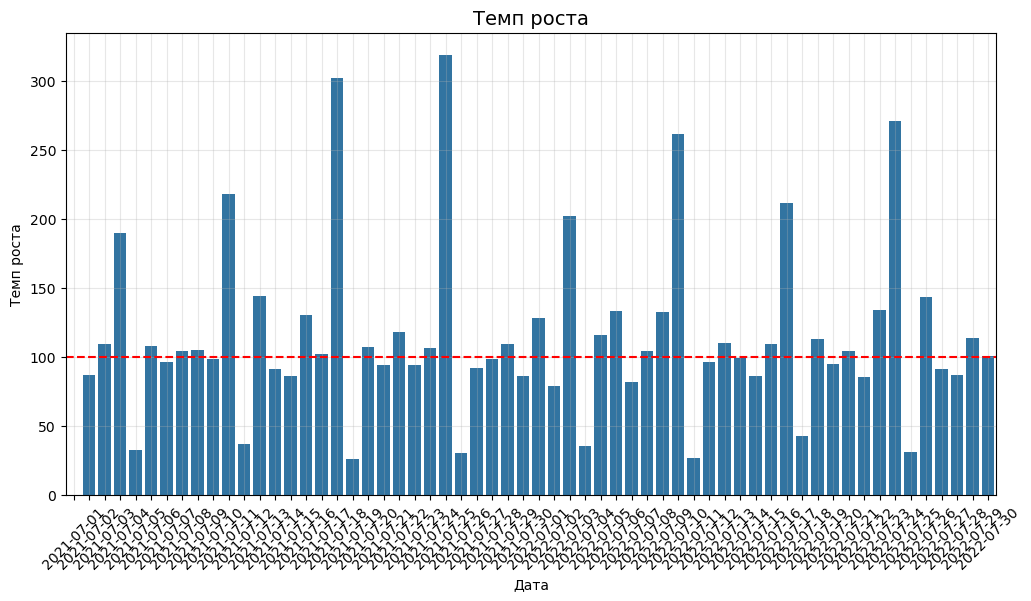

In [61]:
plt.figure(figsize = (12,6))
sns.barplot(prirost, x = 'creation_dt', y = 'temp_rosta')

plt.title('Темп роста', fontsize = 14)
plt.xlabel('Дата')
plt.ylabel('Темп роста')
plt.grid(axis = 'both', alpha = 0.3)

plt.axhline(y=100, color='red', linestyle='--')

plt.xticks(rotation = 45)
plt.show()

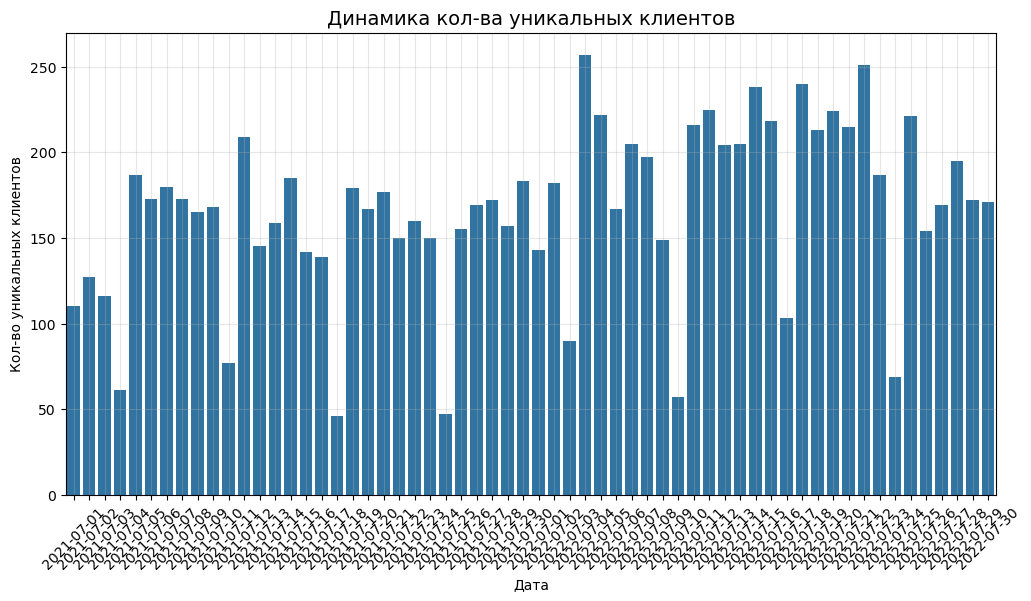

In [63]:
plt.figure(figsize = (12,6))

sns.barplot(prirost, x = 'creation_dt', y = 'user_id')
plt.title('Динамика кол-ва уникальных клиентов', fontsize = 14)
plt.xlabel('Дата')
plt.ylabel('Кол-во уникальных клиентов')
plt.grid(axis = 'both', alpha = 0.3)

plt.xticks(rotation = 45)
plt.show()

### 2. Churn Rate и Retention Rate
Подсказка: считаем не по неделям, а по дням

In [65]:
# в этом задании будет много предупреждений, для удобства просмотра скроем их
import warnings
warnings.filterwarnings('ignore')

In [67]:
ll_soi.login_time = pd.to_datetime(ll_soi.login_time)
ll_soi.creation_time = pd.to_datetime(ll_soi.creation_time)

In [69]:
ll_soi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3396790 entries, 0 to 3396789
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   login_log_id             int64         
 1   user_id                  int64         
 2   login_time               datetime64[ns]
 3   order_id                 object        
 4   fk_buyer_id              float64       
 5   fk_depot_id              float64       
 6   sales_order_status       object        
 7   creation_time            datetime64[ns]
 8   order_item_id            int64         
 9   fk_product_id            int64         
 10  fk_order_id              object        
 11  ordered_quantity         int64         
 12  order_quantity_accepted  int64         
 13  rate                     float64       
 14  creation_dt              object        
dtypes: datetime64[ns](2), float64(3), int64(6), object(4)
memory usage: 388.7+ MB


In [71]:
ll_soi['login_time'] = ll_soi['login_time'].dt.date
ll_soi['creation_time'] = ll_soi['creation_time'].dt.date

In [73]:
# через группировку по покупателю находим минимальную дату и запишем в новый датасет
min_df = ll_soi.groupby('user_id').agg({'creation_time': 'min'}).reset_index()
min_df.rename(columns={"creation_time": "min_date"}, inplace=True) #переименуем
min_df = min_df.sort_values(by = 'min_date').reset_index(drop=True)
min_df.head(3)

,user_id,min_date
0,98908,2021-07-01
1,68000,2021-07-01
2,44288,2021-07-01


In [75]:
# аналогично для максимальной даты
max_df = ll_soi.groupby('user_id').agg({'creation_time': 'max'}).reset_index()
max_df.rename(columns = {'creation_time':'last_date'}, inplace = True)
max_df = max_df.sort_values(by = 'last_date').reset_index(drop=True)
max_df.head(3)

,user_id,last_date
0,70876,2021-07-01
1,68092,2021-07-01
2,76096,2021-07-01


In [77]:
# объединим таблицы через общий ключ (покупателя)
merged_df = max_df.merge(min_df, on = 'user_id', how = 'inner')
merged_df[:3]

,user_id,last_date,min_date
0,70876,2021-07-01,2021-07-01
1,68092,2021-07-01,2021-07-01
2,76096,2021-07-01,2021-07-01


In [79]:
# найдем разницу между максимальной и минимальной датой - срок жизни покупателя
merged_df['lifetime'] = merged_df['last_date']-merged_df['min_date']
merged_df[:3]

,user_id,last_date,min_date,lifetime
0,70876,2021-07-01,2021-07-01,0:00:00
1,68092,2021-07-01,2021-07-01,0:00:00
2,76096,2021-07-01,2021-07-01,0:00:00


In [81]:
#создаем сводную таблицу как в Excel
cr_rr = pd.pivot_table(merged_df, # датасет, по которому строим
                       index = 'min_date', # то что уйдет в строки - первый день захода
                       columns='lifetime', # то что уйдет в столбцы - срок жизни
                       values = 'user_id', # то что уйдет в ячейки и сагригируется - покупатели
                       aggfunc='nunique', # то, как считаются покупатели (нужны уникальные)
                       fill_value = 0 # нулями заполнятся отсутствующие значения
                       )
cr_rr.head(2)

lifetime,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,385 days,386 days,387 days,388 days,389 days,390 days,391 days,392 days,393 days,394 days
min_date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,40,3,0,0,1,1,2,3,1,1,...,0,2,0,0,0,3,2,3,1,1
2021-07-02,43,1,0,1,1,1,3,1,1,0,...,1,6,1,6,1,2,2,2,1,0


In [83]:
# RR - Retention Rate (коэффициент удержания клиентов)
cr_rr.iloc[:, 1:] = cr_rr.iloc[:,1:].div(cr_rr.iloc[:, 0], axis = 0) 

In [85]:
CR = cr_rr.copy()
RR = cr_rr.copy()
CR.iloc[:, 1] = 1 - CR.iloc[:, 1:]
CR[:2]

lifetime,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,385 days,386 days,387 days,388 days,389 days,390 days,391 days,392 days,393 days,394 days
min_date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,40,0.925000,0.0,0.000000,0.025000,0.025000,0.050000,0.075000,0.025000,0.025,...,0.000000,0.050000,0.000000,0.000000,0.000000,0.075000,0.050000,0.075000,0.025000,0.025
2021-07-02,43,0.976744,0.0,0.023256,0.023256,0.023256,0.069767,0.023256,0.023256,0.000,...,0.023256,0.139535,0.023256,0.139535,0.023256,0.046512,0.046512,0.046512,0.023256,0.000


In [87]:
#сделаем более коректный и приятный для интерпретации вид
RR.iloc[:, 1:] = RR.iloc[:, 1:].map(lambda x: f"{x:.2%}")
CR.iloc[0:,1:] = CR.iloc[:, 1:].map(lambda x: f"{x:.2%}")

#display(CR[:2], RR[:2])

**Разобьем сводную таблицу на 2021 и 2022 годы и выведем результаты**

In [614]:
CR2021 = CR[pd.to_datetime(CR.index).year == 2021]
CR2022 = CR[pd.to_datetime(CR.index).year == 2022]
RR2021 = RR[pd.to_datetime(RR.index).year == 2021]
RR2022 = RR[pd.to_datetime(RR.index).year == 2022]
display('Churn Rate 2021'.center(140, '='), CR2021.iloc[[0,14,29]], 'Churn Rate 2022'.center(140, '='), CR2022.iloc[[0,14,29]], 
        'Retention Rate 2021'.center(140, '='), RR2021.iloc[[0,14,29]], 'Retention Rate 2022'.center(140, '='), RR2022.iloc[[0,14,29]])

'==============================================================Churn Rate 2021==============================================================='

lifetime,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,385 days,386 days,387 days,388 days,389 days,390 days,391 days,392 days,393 days,394 days
min_date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,40,92.50%,0.00%,0.00%,2.50%,2.50%,5.00%,7.50%,2.50%,2.50%,...,0.00%,5.00%,0.00%,0.00%,0.00%,7.50%,5.00%,7.50%,2.50%,2.50%
2021-07-15,62,93.55%,3.23%,1.61%,0.00%,1.61%,0.00%,0.00%,3.23%,3.23%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2021-07-30,55,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


'==============================================================Churn Rate 2022==============================================================='

lifetime,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,385 days,386 days,387 days,388 days,389 days,390 days,391 days,392 days,393 days,394 days
min_date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,45,86.67%,2.22%,11.11%,2.22%,8.89%,4.44%,4.44%,0.00%,2.22%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2022-07-15,53,96.23%,0.00%,9.43%,7.55%,3.77%,3.77%,5.66%,3.77%,1.89%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2022-07-30,54,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


'============================================================Retention Rate 2021============================================================='

lifetime,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,385 days,386 days,387 days,388 days,389 days,390 days,391 days,392 days,393 days,394 days
min_date,,,,,,,,,,,,,,,,,,,,,
2021-07-01,40,7.50%,0.00%,0.00%,2.50%,2.50%,5.00%,7.50%,2.50%,2.50%,...,0.00%,5.00%,0.00%,0.00%,0.00%,7.50%,5.00%,7.50%,2.50%,2.50%
2021-07-15,62,6.45%,3.23%,1.61%,0.00%,1.61%,0.00%,0.00%,3.23%,3.23%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2021-07-30,55,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


'============================================================Retention Rate 2022============================================================='

lifetime,0 days,1 days,2 days,3 days,4 days,5 days,6 days,7 days,8 days,9 days,...,385 days,386 days,387 days,388 days,389 days,390 days,391 days,392 days,393 days,394 days
min_date,,,,,,,,,,,,,,,,,,,,,
2022-07-01,45,13.33%,2.22%,11.11%,2.22%,8.89%,4.44%,4.44%,0.00%,2.22%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2022-07-15,53,3.77%,0.00%,9.43%,7.55%,3.77%,3.77%,5.66%,3.77%,1.89%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
2022-07-30,54,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,...,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%


### 3. Daily Active User (DAU)

In [89]:
ll_soi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3396790 entries, 0 to 3396789
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   login_log_id             int64  
 1   user_id                  int64  
 2   login_time               object 
 3   order_id                 object 
 4   fk_buyer_id              float64
 5   fk_depot_id              float64
 6   sales_order_status       object 
 7   creation_time            object 
 8   order_item_id            int64  
 9   fk_product_id            int64  
 10  fk_order_id              object 
 11  ordered_quantity         int64  
 12  order_quantity_accepted  int64  
 13  rate                     float64
 14  creation_dt              object 
dtypes: float64(3), int64(6), object(6)
memory usage: 388.7+ MB


In [91]:
ll_soi['date'] = pd.to_datetime(ll_soi['creation_time']).dt.date
ll_soi['year'] = pd.to_datetime(ll_soi['creation_time']).dt.year
ll_soi['month'] = pd.to_datetime(ll_soi['creation_time']).dt.month

In [92]:
DAU = ll_soi.groupby('date').agg({'user_id': 'nunique'})
DAU.rename(columns={'user_id':'DAU'}, inplace = True)
DAU.head()

,DAU
date,
2021-07-01,110
2021-07-02,127
2021-07-03,116
2021-07-04,61
2021-07-05,187


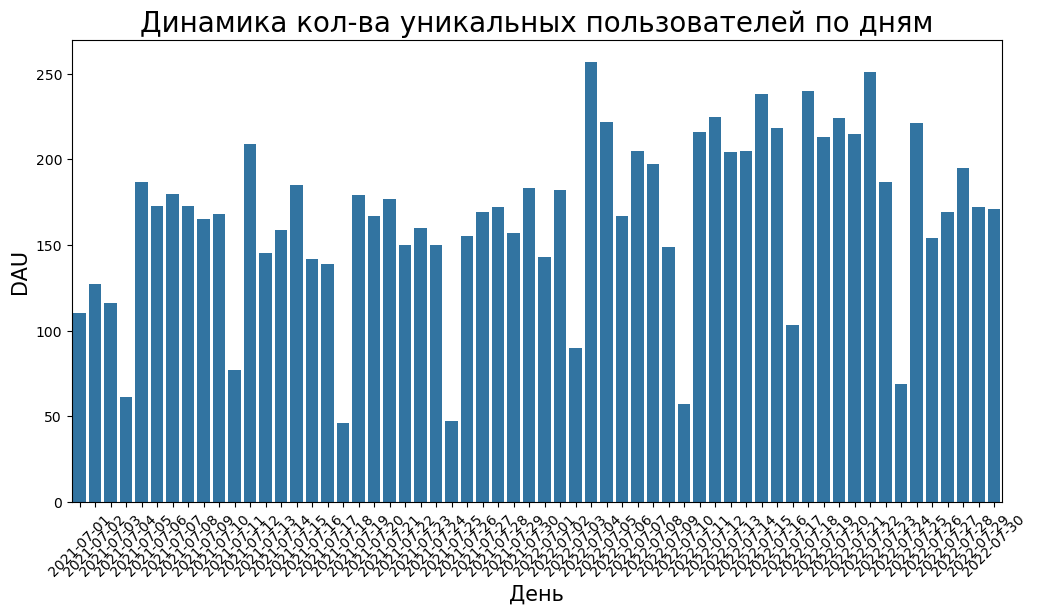

In [95]:
plt.figure(figsize = (12,6))

sns.barplot(DAU, x = 'date', y = 'DAU') 
plt.title('Динамика кол-ва уникальных пользователей по дням', fontsize = 20)
plt.xlabel('День', fontsize = 15)
plt.ylabel('DAU', fontsize = 15)
plt.xticks(rotation = 45)

plt.show()

### 4. Monthly Active User (MAU)

In [97]:
#попробуйте решить самостоятельно (нужна группировка пользователей по месяцу)
MAU_month = ll_soi.groupby(['year', 'month']).agg({'user_id':'nunique'})
MAU_month

,,user_id
year,month,
2021,7,2452
2022,7,2980


### 5. Наиболее популярные продаваемые товары (топ-10)

In [99]:
ll_soi[:3]

,login_log_id,user_id,login_time,order_id,fk_buyer_id,fk_depot_id,sales_order_status,creation_time,order_item_id,fk_product_id,fk_order_id,ordered_quantity,order_quantity_accepted,rate,creation_dt,date,year,month
0,1385328,99160,2021-07-01,126408,99160.0,9.0,Shipped,2021-07-11,66092,12749,126408,2,2,4025.42,11 - 07 - 2021,2021-07-11,2021,7
1,1385328,99160,2021-07-01,138030,99160.0,9.0,Rejected,2021-07-30,72199,11118,138030,1,0,2722.00,30 - 07 - 2021,2021-07-30,2021,7
2,1385328,99160,2021-07-01,138030,99160.0,9.0,Rejected,2021-07-30,72200,11118,138030,1,0,2478.00,30 - 07 - 2021,2021-07-30,2021,7


In [103]:
Regected_but_accepted = ll_soi.query("sales_order_status == 'Rejected' and order_quantity_accepted != 0")
Shipped_bup_not_accepted = ll_soi.query("sales_order_status == 'Shipped' and order_quantity_accepted == 0")
print(len(Regected_but_accepted), len(Shipped_bup_not_accepted))

1611 99821


**Ошибки сбора/ввода данных?**

In [105]:
#попробуйте решить самостоятельно (сколько единиц продано каждого товара? группировка)
ll_soi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3396790 entries, 0 to 3396789
Data columns (total 18 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   login_log_id             int64  
 1   user_id                  int64  
 2   login_time               object 
 3   order_id                 object 
 4   fk_buyer_id              float64
 5   fk_depot_id              float64
 6   sales_order_status       object 
 7   creation_time            object 
 8   order_item_id            int64  
 9   fk_product_id            int64  
 10  fk_order_id              object 
 11  ordered_quantity         int64  
 12  order_quantity_accepted  int64  
 13  rate                     float64
 14  creation_dt              object 
 15  date                     object 
 16  year                     int32  
 17  month                    int32  
dtypes: float64(3), int32(2), int64(6), object(7)
memory usage: 440.6+ MB


In [107]:
top10_sales_orders = ll_soi.query("sales_order_status == 'Shipped' and order_quantity_accepted != 0") #чтобы чуть-чуть сэкономить память, кааапельку
top10_sales_orders = top10_sales_orders.groupby('fk_product_id').agg({'order_quantity_accepted':'sum'}).sort_values(by = 'order_quantity_accepted', ascending = False).reset_index()
                                                          
top10_sales_orders[:11]

,fk_product_id,order_quantity_accepted
0,10235,242275
1,8444,235201
2,8219,216959
3,8428,185467
4,12652,153709
5,9916,116896
6,7640,104469
7,12749,102865
8,8221,102734
9,3610,97392


In [109]:
print('Топ 10 самых продаваемых товаров'.center(135, '='))
top10_sales_orders[:11].style.format({'order_quantity_accepted': '{:,}'})

====================================================Топ 10 самых продаваемых товаров===================================================


,fk_product_id,order_quantity_accepted
0,10235,"242,275"
1,8444,"235,201"
2,8219,"216,959"
3,8428,"185,467"
4,12652,"153,709"
5,9916,"116,896"
6,7640,"104,469"
7,12749,"102,865"
8,8221,"102,734"
9,3610,"97,392"


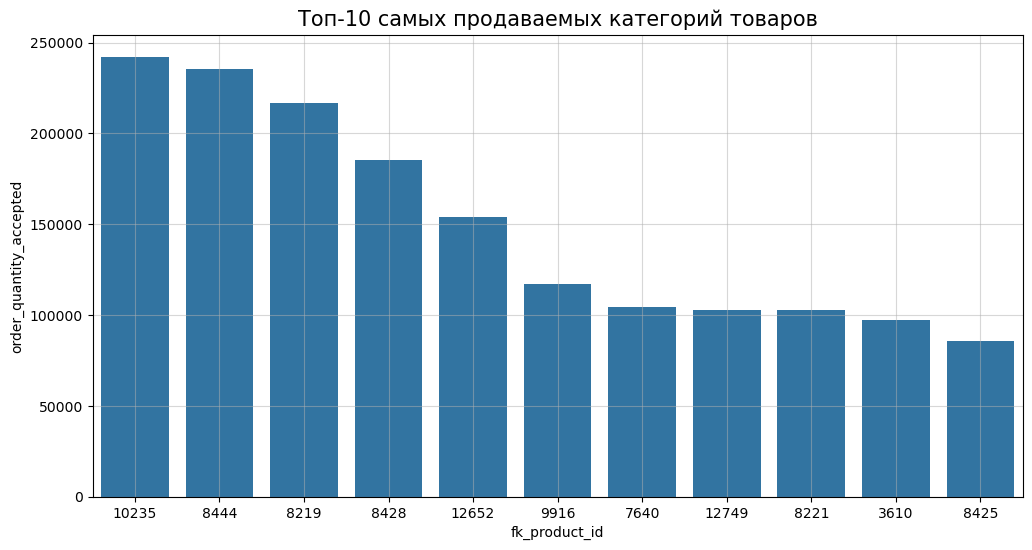

In [111]:
plt.figure(figsize = (12,6))

top10_sales_orders['fk_product_id'] = top10_sales_orders['fk_product_id'].astype(str)

sns.barplot(top10_sales_orders[0:11], x = 'fk_product_id', y = 'order_quantity_accepted')
plt.title('Топ-10 самых продаваемых категорий товаров', fontsize = 15)
plt.grid('both', alpha = 0.5)

### 6. Товары с самым высоким доходом

In [123]:
# также через группировку, но надо учесть 'sales_order_status' == 'Shipped'
# выручка = количество * цена
# переименуем rate в price 
ll_soi.rename(columns = {'rate':'price'}, inplace = True)
product_revenue = ll_soi.query("sales_order_status == 'Shipped'")
product_revenue = product_revenue[['price', 'order_quantity_accepted', 'fk_product_id']]
product_revenue['revenue'] = product_revenue['price']*product_revenue['order_quantity_accepted']
top10_product_revenue = product_revenue.groupby('fk_product_id').agg({'revenue':'sum'}).sort_values(by = 'revenue', ascending = False).reset_index()
print('Топ 10 товаров с самым высоким доходом'.center(125, '='))
top10_product_revenue[:11].style.format({'revenue': '{:,}'})

============================================Топ 10 товаров с самым высоким доходом===========================================


,fk_product_id,revenue
0,8219,"3,000,854,854.5"
1,7640,"1,582,154,654.6"
2,8444,"1,452,183,936.8"
3,12652,"1,170,098,419.0"
4,3610,"1,163,473,068.0"
5,8210,"870,829,129.0"
6,10975,"828,708,210.96"
7,12749,"626,918,438.59"
8,12547,"533,559,012.0"
9,8221,"410,262,898.61"


In [125]:
#переведем в миллионы выручку для удобства визуализации
top10_product_revenue['revenue'] = top10_product_revenue['revenue'] / 1000000  

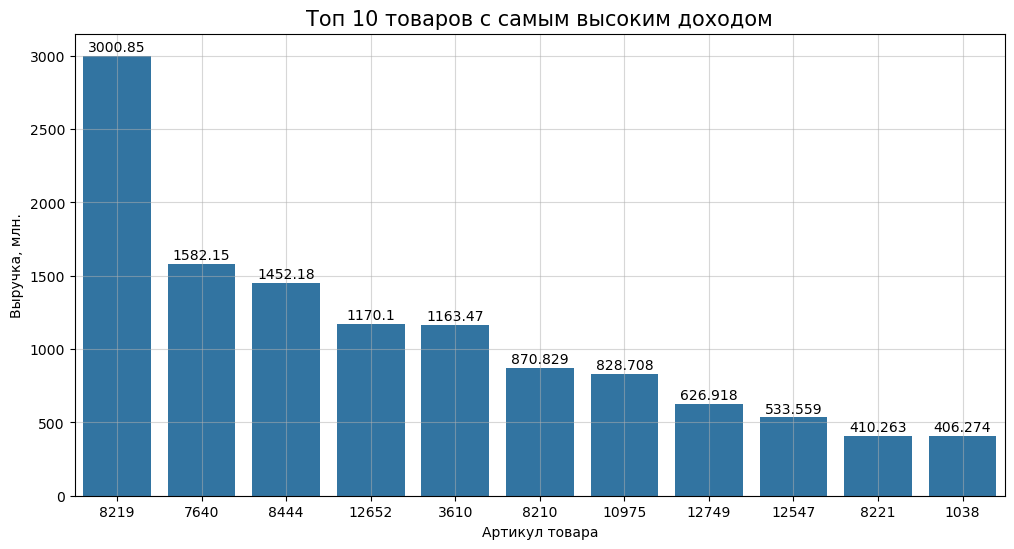

In [127]:
plt.figure(figsize = (12,6))

top10_product_revenue['fk_product_id'] = top10_product_revenue['fk_product_id'].astype(str)

ax = sns.barplot(top10_product_revenue[:11], x = 'fk_product_id', y = 'revenue')
ax.bar_label(ax.containers[0], padding=1)

plt.title('Топ 10 товаров с самым высоким доходом', fontsize = 15)
plt.ylabel('Выручка, млн.')
plt.xlabel('Артикул товара')
plt.grid(alpha = 0.5)
plt.show()

### 7. Объем выручки

In [129]:
# просуммируем за все даты на основе данных из прошлого задания
product_revenue['date'] = ll_soi['date']
product_revenue_by_date = product_revenue.groupby('date').agg({'revenue':'sum'}).sort_values('revenue', ascending = False).reset_index() 
product_revenue_by_date[:11].style.format({'revenue':'{:,}'})


,date,revenue
0,2022-07-07,"1,588,228,536.11"
1,2022-07-14,"1,471,348,989.2"
2,2022-07-11,"1,035,212,145.54"
3,2022-07-22,"877,930,656.96"
4,2022-07-18,"869,176,343.88"
5,2022-07-04,"854,486,104.37"
6,2022-07-15,"784,137,600.46"
7,2022-07-21,"715,967,487.84"
8,2022-07-05,"671,549,310.54"
9,2022-07-19,"663,480,779.0"


**2022 гораздо более успешный чем 2021**

In [131]:
full_revenue = sum(product_revenue['revenue'])
print('Общий объем выручки:', end = ' ')
print(f"{full_revenue:,.3f}") 

Общий объем выручки: 25,147,361,247.328


### Может ли статус заказа повлиять на эффективность компании?

In [273]:
#div = (eff['sales_order_status'] == 'Rejected').sum() / (eff['sales_order_status'] == 'Shipped').sum()
div= eff.iloc[1,1]/(eff.iloc[3,1])
div*100-100

3.448110692558089

In [259]:
eff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sales_order_status  4 non-null      object 
 1   revenue             4 non-null      float64
dtypes: float64(1), object(1)
memory usage: 196.0+ bytes


In [267]:
# посмотрите статистику по заказам (кол-во отмененных, в пути и т.д.) 
ll_soi['revenue'] = ll_soi['ordered_quantity']*ll_soi['price']
eff = ll_soi.groupby('sales_order_status').agg({'revenue':'sum'}).reset_index()
div= eff.iloc[1,1]/(eff.iloc[3,1])
eff['revenue'] = eff['revenue'].apply(lambda x: f"{x:.2f}")
display(eff[:4], div)


eff

,sales_order_status,revenue
0,Pending,3.605877e+08
1,Rejected,2.727939e+10
2,Review,5.344000e+04
3,Shipped,2.637012e+10


## 27279388887.43 мы потеряли из-за отмены заказов(, более того, выручка меньше потерянной суммы из-за отмененных заказов всего на 3,448%, из этого можно сделать вывод, что компании нужно срочно рассмотреть причины и способы снижения столь высокого уровня отказа заказов

### Влияет ли частота входа на сайт на количество совершаемых заказов?

In [139]:
print(ll_soi['login_time'].head(5))
print(ll_soi['login_time'].dtype)

0    2021-07-01
1    2021-07-01
2    2021-07-01
3    2021-07-01
4    2021-07-01
Name: login_time, dtype: object
object


In [141]:
# найдите для каждого дня частоту входа и количество заказов
log_ord = ll_soi[['login_time', 'creation_time', 'ordered_quantity', 'login_log_id']]
log_ord['date'] = pd.to_datetime(log_ord['creation_time']).dt.date
log_ord = log_ord.groupby('date').agg({'ordered_quantity':'sum','login_log_id':'count' })
log_ord=log_ord.rename(columns ={'ordered_quantity':'quantity_of_orders','login_log_id':'quantity_of_logins'})

# посчитайте коэффициент корреляции (corr)
correlation = log_ord['quantity_of_logins'].corr(log_ord['quantity_of_orders'])
print(f"Корреляция между частотой входом пользователей и количеством заказов: {correlation:.4f}")

Корреляция между частотой входом пользователей и количеством заказов: 0.8218
